In [23]:
%matplotlib inline

import numpy as np # Linear algebra
import pandas as pd # Data processing, read CSV file

from PIL import Image

import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

os.listdir('./input/')

['.DS_Store', 'test', 'train', 'train.csv', 'sample_submission.csv']

# Helper code

In [2]:
# Target labels
LABEL_MAP = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",   
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Peroxisomes",
    9:  "Endosomes",
    10: "Lysosomes",
    11: "Intermediate filaments", 
    12: "Actin filaments",
    13: "Focal adhesion sites",
    14: "Microtubules",
    15: "Microtubule ends",
    16: "Cytokinetic bridge",
    17: "Mitotic spindle",
    18: "Microtubule organizing center",  
    19: "Centrosome",
    20: "Lipid droplets",
    21: "Plasma membrane",
    22: "Cell junctions",
    23: "Mitochondria",
    24: "Aggresome",
    25: "Cytosol",
    26: "Cytoplasmic bodies",
    27: "Rods & rings"
}

# Defines
DIM_HEIGHT = DIM_WIDTH = 512
N_CHANNELS = 4

# Create Dataset

In [3]:
class HumanProteinDataset(Dataset):
    
    def __init__(self, path_to_csv, transform=True, test=False):
        """
        Construct Human Protein Dataset.
        
        Args
            path_to_csv: 
                Path to csv file
            transform:
                Transform data to torch Tensors and normalize image pixel values. (Default: True)
            test:
                If True constructs test dataset. (Default: False)
        """
        self.transform = transform
        self.test = test
        
        # create dataframe from CSV file
        self.df = pd.read_csv(path_to_csv)
        
        if not self.test:
            # modify dataframe with columns representing all classes and map corresponding target values (1 or 0)
            for n in range(len(LABEL_MAP)):
                self.df[f'{LABEL_MAP.get(n)}'] = self.df['Target'].map(
                lambda x: 1 if str(n) in x.strip().split() else 0)
        
        if not self.test:
            self.path = './input/train/'
        else:
            self.path = './input/test/'
            
        
    def __getitem__(self, idx):
        """
        Support integer indexing on dataset (range 0 to len(self)).
        """
        
        Id = self.df['Id'].iloc[idx]
        Targets = np.zeros(len(LABEL_MAP))
        
        if not self.test:
            for i, label in enumerate(LABEL_MAP.values()):
                if self.df[label].iloc[idx] == 1:
                    Targets[i] = 1
            
        images = np.zeros(shape=(DIM_HEIGHT, DIM_WIDTH, N_CHANNELS))
        images[:,:,0] = np.asarray(Image.open(self.path + Id + "_red" + ".png"))
        images[:,:,1] = np.asarray(Image.open(self.path + Id + "_green" + ".png"))
        images[:,:,2] = np.asarray(Image.open(self.path + Id + "_blue" + ".png"))
        images[:,:,3] = np.asarray(Image.open(self.path + Id + "_yellow" + ".png"))
        
        sample = {'Id': Id, 'Targets': Targets, 'Images':images}
        
        if self.transform:
            # normalize pixel values in image from [0, 255] to [0, 1]
            images = sample['Images']
            images_norm = np.copy(images)
            images_norm /= 255.
            
            #images_norm = sample['Images']/255.0
            
            # convert from numpy array to torch Tensor
            sample = {'Id': Id, 'Targets': torch.from_numpy(Targets), 'Images': torch.from_numpy(images_norm)}

        return sample
    
    def __len__(self):
        """
        Get length of dataset.
        """
        return len(self.df)

In [4]:
dataset = HumanProteinDataset('./input/train.csv', transform=True)
dataset.df.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Show Images from Samples
Next I'm going to visualize the data images.

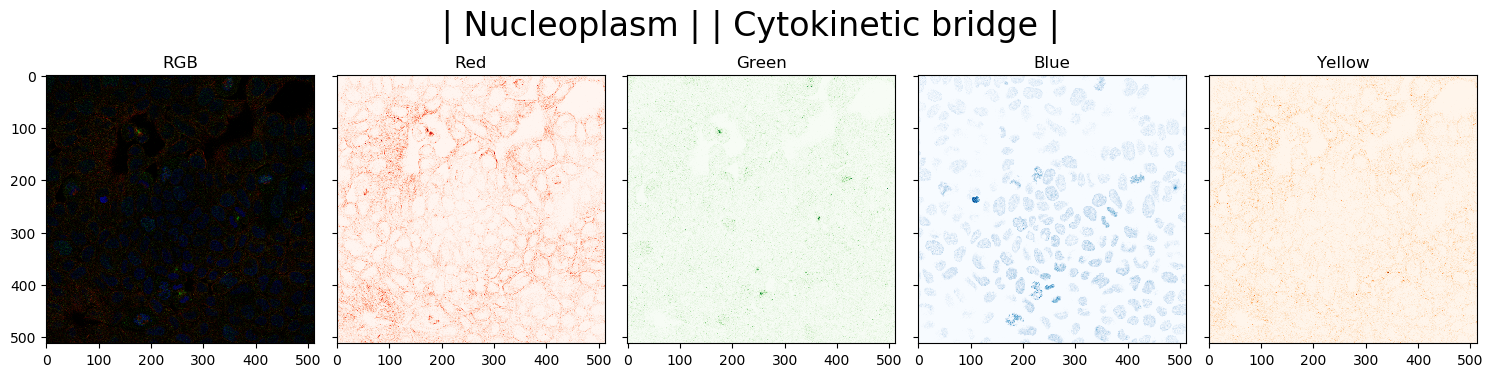

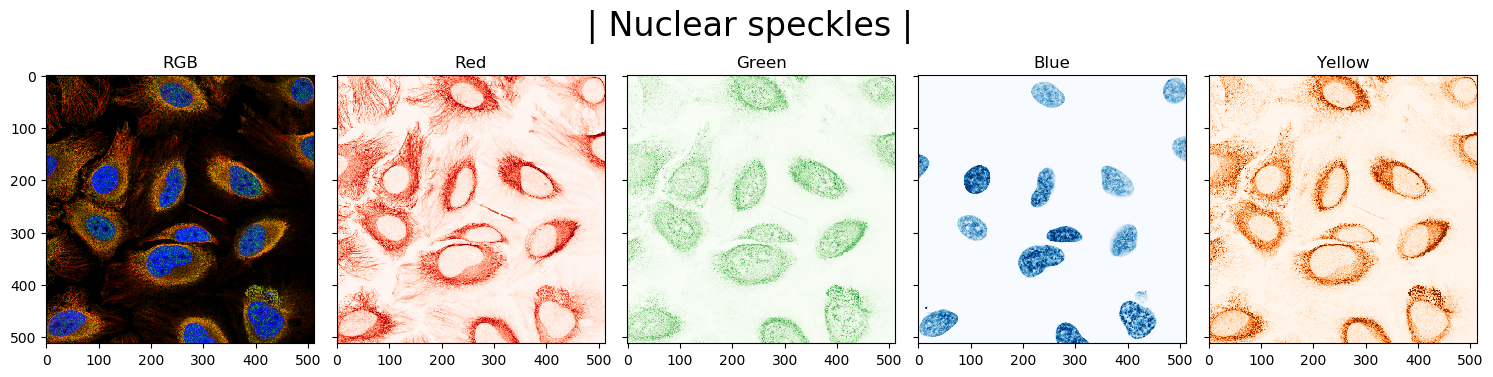

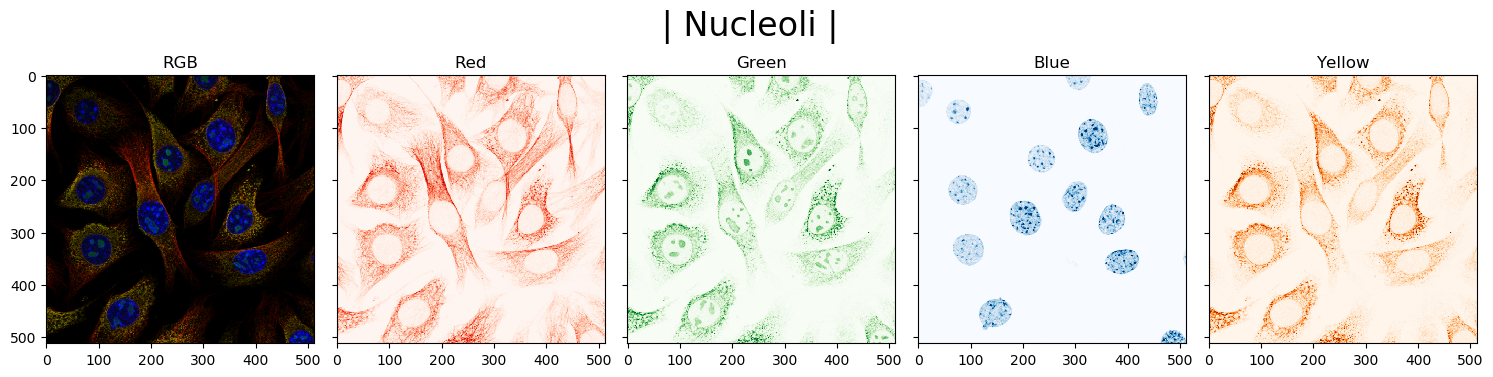

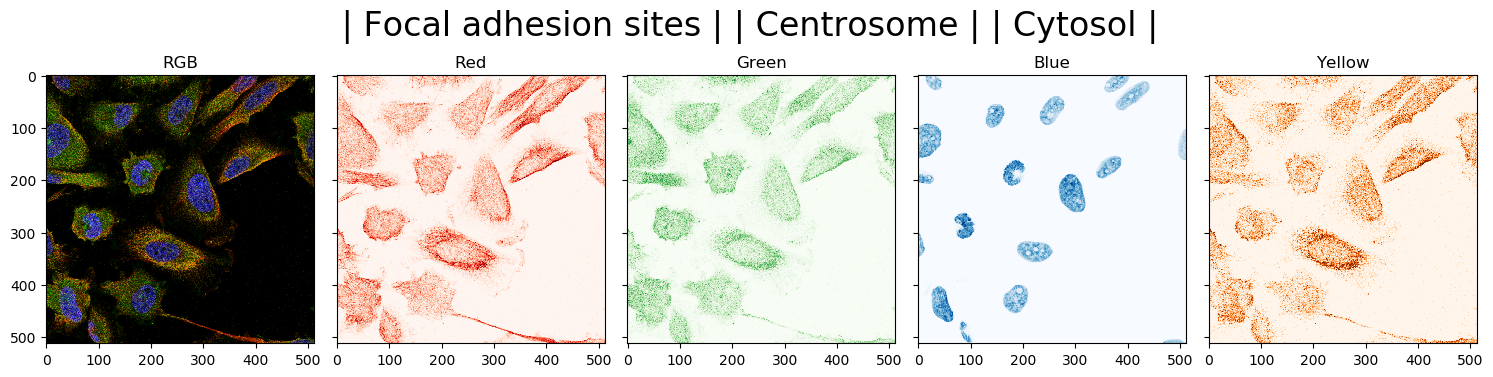

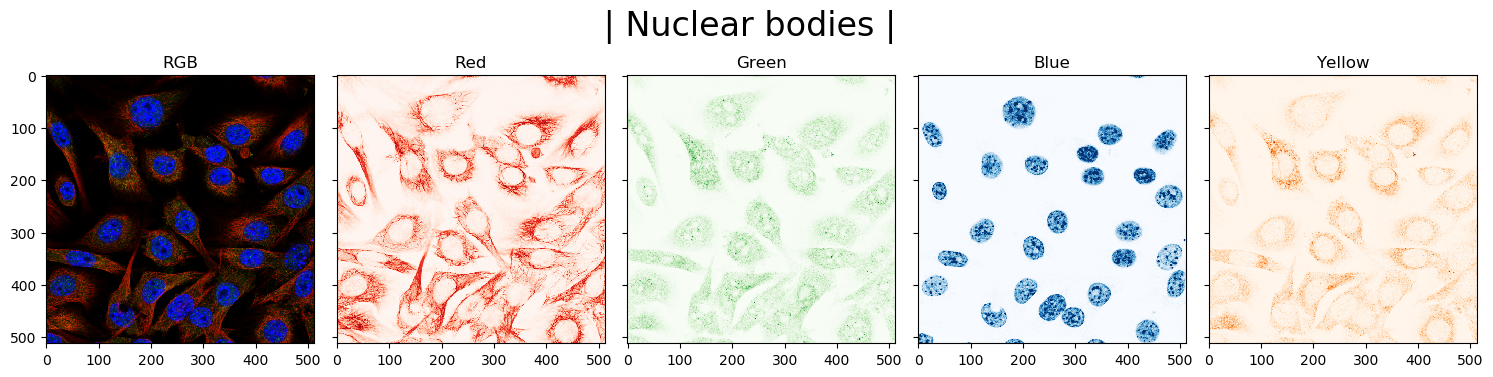

In [31]:
def show_images(sample):
    """
    Displays images for a specific ID in the colors red, green, blue, yellow and RGB.
    """
    cols = 4
    rows = 3
    title = ''
    
    # title is target labels in sample
    labels = []
    for label in LABEL_MAP.values():
        labels.append(label)
    
    for Id, label in enumerate(labels):
        if sample['Targets'][Id] == 1:
            title += ' | ' + label + ' |'
    
    mpl.style.use('default')
    fig, axs = plt.subplots(1, 5, figsize=(15,10), sharey=True)
    
    # construct RGB image
    # exclude yellow
    RGB = sample['Images'][:,:,:-1]
    # add yellow color to RGB
    # yellow is composed of red+green -> blue has yellow, add yellow only to red and green
    RGB[:,:,0] += sample['Images'][:,:,3]
    RGB[:,:,1] += sample['Images'][:,:,3]
    # normalize red and green colors again
    RGB[:,:,0] /= 2
    RGB[:,:,1] /= 2
    
    # plot images
    axs[0].imshow(RGB)
    axs[0].set_title('RGB')
    axs[1].imshow(sample['Images'][:,:,0], cmap="Reds")
    axs[1].set_title('Red')
    axs[2].imshow(sample['Images'][:,:,1], cmap='Greens')
    axs[2].set_title('Green')
    axs[3].imshow(sample['Images'][:,:,2], cmap="Blues")
    axs[3].set_title('Blue')
    axs[4].imshow(sample['Images'][:,:,3], cmap="Oranges")
    axs[4].set_title('Yellow')
    fig.suptitle(title, fontsize=24, y=0.7)
    plt.tight_layout()
    
for i in range(5):
    show_images(dataset[i*2000])

# Most Occuring Target in Dataset

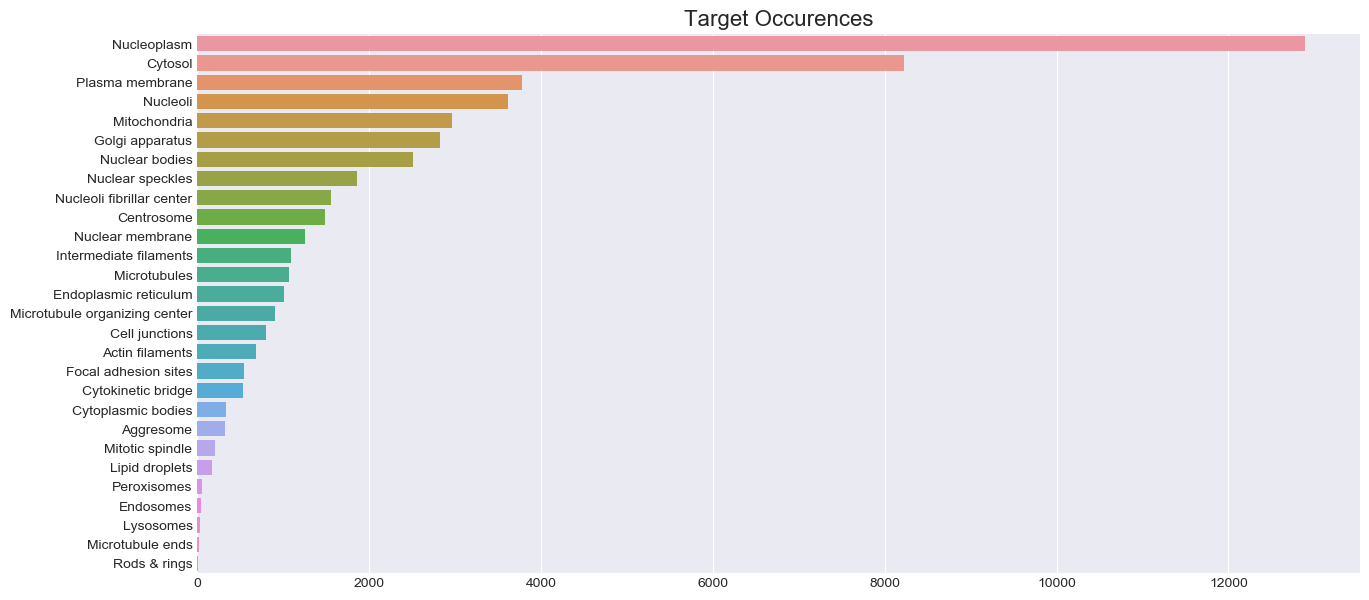

In [6]:
# get total for each target label and sort
counts = dataset.df.drop(columns=['Id', 'Target'], inplace=False).sum(axis=0).sort_values(ascending=False)

# plot results
plt.figure(figsize=(15, 7))
mpl.style.use('seaborn-darkgrid')
sns.barplot(x=counts.values, y=counts.index.values)
plt.title('Target Occurences', fontsize=16)
plt.show()

## Insights
*There seems to be some targets that are very rare in the dataset. The target labels: **Rods & rings, Microtubule, Lysosomes, Endosomes and Peroxisomes** might be hard to classify as the network might fail to detect them in the images during training.*

# Define a Convolutional Neural Network

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    
    def __init__(self, channels):
        super(Net, self).__init__()
        self.channels = channels
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.ReLU(inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=0),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.ReLU(inplace=True)
        )
        
        # Dense layers
#        self.fc1 = nn.Sequential(
#            nn.Linear(in_features=, 
#                      out_features=750, 
#                      bias=True))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        print(x.shape)
        x = x.view(-1)
        
        return x
    
net = Net(N_CHANNELS).to(device)
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
  )
)


In [30]:
# Test forward pass
x = np.random.uniform(0, 1, size=(10, 4, 512, 512)).astype('float32')
x = torch.autograd.Variable(torch.from_numpy(x))

out = net(x)
out.shape

torch.Size([10, 32, 125, 125])


torch.Size([10, 32, 125, 125])

# Train CNN

In [ ]:
# define a loss function and an optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

N_EPOCHS = 10

while n < N_EPOCHS:
    
    try:
        
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        break